In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import ssl
import certifi
import io
import stockfish
import datetime
import matplotlib.pyplot as plt

## Import chess.com data based on username and desired years, then create a database called my_games.

In [2]:

ssl_cert_file = certifi.where()
ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS_CLIENT)
ssl_context.load_verify_locations(ssl_cert_file)

my_games = pd.DataFrame(columns = ['datetime', 'my color', 'time format', 'time control', 'my rating', 'opponent rating', 'result', 'opponent result']) #sets up the data frame to store games

year_start = 2020
year_end = 2023
months = range(1,13)
for year in range(year_start, year_end + 1):
    for month in months:
        try: 
            url = f'https://api.chess.com/pub/player/jnbradley828/games/{str(year)}/{month:02}'
            response = urlopen(url, context=ssl_context)
            data = response.read().decode('utf-8', 'replace')
            data = pd.read_json(io.StringIO(data))
        except:
            print(month, year, 'could not be parsed because of future date')

        for game in data['games']:
            if game['rated'] == True and game['rules'] == 'chess':
                my_username = 'jnbradley828'
                my_color = ''
                opp_color = ''
                if game['white']['username'] == my_username:
                    my_color = 'white'
                    opp_color = 'black'
                elif game['black']['username'] == my_username:
                    my_color = 'black'
                    opp_color = 'white'

                new_row = pd.DataFrame({
                    'datetime': [datetime.datetime.fromtimestamp(game['end_time'])], #important to note that this outputs the time in your system's timezone.
                    'my color': [my_color],
                    'time format': [game['time_class']],
                    'time control': [game['time_control']],
                    'my rating': [game[my_color]['rating']],
                    'opponent rating': [game[opp_color]['rating']],
                    'result': [game[my_color]['result']],
                    'opponent result': [game[opp_color]['result']],
                          })
                my_games = pd.concat([my_games, new_row], ignore_index=True)

my_games.set_index('datetime', inplace=True)
print(my_games.head())

/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_3691/930322698.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_games = pd.concat([my_games, new_row], ignore_index=True)


12 2023 could not be parsed because of future date
                    my color time format time control my rating  \
datetime                                                          
2020-02-24 17:10:20    black       daily      1/86400       900   
2020-02-26 21:15:04    white       daily      1/86400      1005   
2020-02-28 20:44:09    black       daily      1/86400       979   
2020-03-01 12:43:54    black       daily      1/86400      1007   
2020-03-01 17:56:33    black       blitz        180+2       835   

                    opponent rating      result opponent result  
datetime                                                         
2020-02-24 17:10:20            1277  checkmated             win  
2020-02-26 21:15:04            1249         win      checkmated  
2020-02-28 20:44:09            1231    resigned             win  
2020-03-01 12:43:54             777         win      checkmated  
2020-03-01 17:56:33             834         win      checkmated  


## From my_games, create a new data frame called time_vs_win that categorizes each game into what hour of day it was played. Include only time format and result.

In [3]:
time_vs_win = pd.DataFrame(columns = ['hour', 'time of day', 'time format', 'result'])
for game in my_games.iloc():
    if game['time format'] == 'daily':
        continue         # We need to exclude daily/correspondence games, because they span multiple days and thus could skew the data based on the time the game ended.
    hour = int(game.name.strftime("%H"))
    if hour < 6 and hour >= 0:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'night', 'time format': game['time format'], 'result': game['result']})
    elif hour < 12 and hour >= 6:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'morning', 'time format': game['time format'], 'result': game['result']})
    elif hour < 18 and hour >= 12:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'afternoon', 'time format': game['time format'], 'result': game['result']})
    elif hour > 18:
        new_row = pd.DataFrame({'hour': [hour], 'time of day': 'evening', 'time format': game['time format'], 'result': game['result']})
    time_vs_win = pd.concat([time_vs_win, new_row], ignore_index=True)

print(time_vs_win.head())
print(time_vs_win['result'].unique())
print(time_vs_win['hour'].unique())

  hour time of day time format result
0   17   afternoon       blitz    win
1   17   afternoon       blitz    win
2   17   afternoon       blitz    win
3   19     evening       rapid    win
4   20     evening       rapid    win
['win' 'resigned' 'checkmated' 'timeout' 'abandoned' 'agreed' 'repetition'
 'timevsinsufficient' 'stalemate' 'insufficient' '50move']
[17 19 20 21 13 14 15 12 22 16 10 11 23 0 8 9 1 7]


## Convert detailed results in time_vs_win (such as 'resigned', 'agreement', etc. ) into numeric chess results (1 = win, 0.5 = draw, 0 = loss).

In [4]:
win = ['win']
draw = ['agreed', 'repetition', 'timevsinsufficient', 'stalemate', 'insufficient', '50move']
loss = ['checkmated', 'resigned', 'timeout', 'abandoned']

def determine_value(row):
    if row['result'] in win:
        return 1
    elif row['result'] in draw:
        return 0.5
    elif row['result'] in loss:
        return 0

time_vs_win['numeric result'] = time_vs_win.apply(determine_value, axis = 1)

## Exclude any hours during the day which contain less than 50 games. Then create a line graph of the probability of winning in all time controls based on hour of day. Then separate by time control, exclude hours with less than 30 games, and add to the plot.

Figure(1000x500)


/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_3691/3280940324.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([map_hours(x) for x in xticks_def])


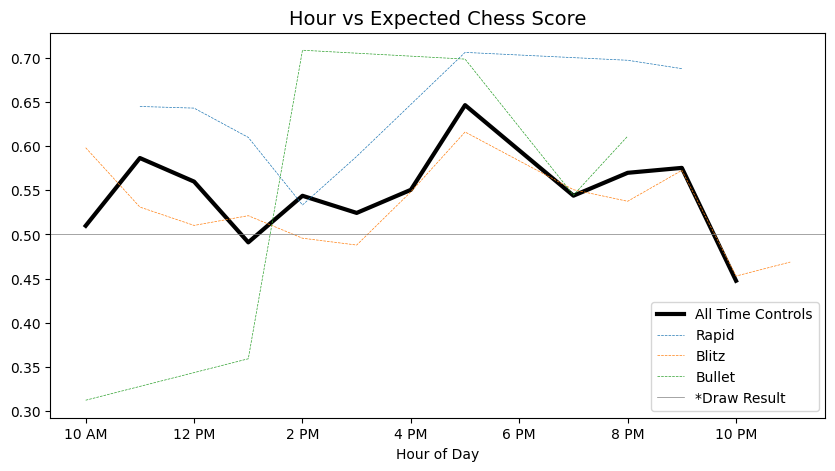

In [5]:
hours_to_exclude = [] #Exclude hours with less than 50 games.
for int in range(0,25):
    try:
        if time_vs_win.groupby('hour').count()['time of day'][int] < 50:
            hours_to_exclude.append(int)
    except:
        continue

_a = time_vs_win.groupby('hour').mean('numeric result').reset_index()
hour_vs_numeric_result = _a[~_a['hour'].isin(hours_to_exclude)]

ax = hour_vs_numeric_result.plot(x = 'hour',
                            y = 'numeric result', 
                            kind = 'line', 
                            figsize = (10,5), 
                            xlabel = 'Hour of Day', 
                            label = 'All Time Controls',
                            legend = False,
                            linewidth = 3,
                            color = 'black'
                                )
ax.set_title('Hour vs Expected Chess Score', fontsize = 14)

## Plot the individual time formats.

_b = time_vs_win.groupby(['time format', 'hour'])['numeric result'].agg(mean = 'mean', count = 'count')

time_vs_win_Rapid = _b.loc['rapid'].reset_index()
time_vs_win_Blitz = _b.loc['blitz'].reset_index()
time_vs_win_Bullet = _b.loc['bullet'].reset_index()

min_count = 30
time_vs_win_Rapid = time_vs_win_Rapid[time_vs_win_Rapid['count'] >= min_count]
time_vs_win_Blitz = time_vs_win_Blitz[time_vs_win_Blitz['count'] >= min_count]
time_vs_win_Bullet = time_vs_win_Bullet[time_vs_win_Bullet['count'] >= min_count]

ax.plot(time_vs_win_Rapid['hour'], time_vs_win_Rapid['mean'], label = 'Rapid', linestyle = '--', linewidth = .5)
ax.plot(time_vs_win_Blitz['hour'], time_vs_win_Blitz['mean'], label = 'Blitz', linestyle = '--', linewidth = .5)
ax.plot(time_vs_win_Bullet['hour'], time_vs_win_Bullet['mean'], label = 'Bullet', linestyle = '--', linewidth = .5)

ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw Result', linewidth = 0.5)
ax.legend()

#Change x ticks to standard time labels.
def map_hours(x):
    x_int = x.item()
    hour_mapping = {
        0: '12 AM',
        1: '1 AM',
        2: '2 AM',
        3: '3 AM',
        4: '4 AM',
        5: '5 AM',
        6: '6 AM',
        7: '7 AM',
        8: '8 AM',
        9: '9 AM',
        10: '10 AM',
        11: '11 AM',
        12: '12 PM',
        13: '1 PM',
        14: '2 PM',
        15: '3 PM',
        16: '4 PM',
        17: '5 PM',
        18: '6 PM',
        19: '7 PM',
        20: '8 PM',
        21: '9 PM',
        22: '10 PM',
        23: '11 PM',
        24: ''
    }
    return hour_mapping[x_int]
    
xticks_def = ax.get_xticks()
ax.set_xticklabels([map_hours(x) for x in xticks_def])


fig = ax.get_figure()
fig.savefig('Hours vs Expected Result.png')
print(fig)

In [6]:
my_games = my_games.reset_index()
my_games['games in last week'] = None

## Add numeric results and games in last week to my_games (this could be more efficient if I added numeric results earlier, as the code was copied from above.

In [7]:
for index, game in my_games.iterrows():
    time_from_game_df = game['datetime'] - my_games['datetime']
    count_within_week = len(time_from_game_df[(time_from_game_df <= datetime.timedelta(days=7)) & (time_from_game_df > datetime.timedelta(days=0))])
    my_games.loc[index, 'games in last week'] = count_within_week

win = ['win']
draw = ['agreed', 'repetition', 'timevsinsufficient', 'stalemate', 'insufficient', '50move']
loss = ['checkmated', 'resigned', 'timeout', 'abandoned']

def determine_value(row):
    if row['result'] in win:
        return 1
    elif row['result'] in draw:
        return 0.5
    elif row['result'] in loss:
        return 0

my_games['numeric result'] = my_games.apply(determine_value, axis = 1)


## Filter out weekly game amounts with less than 30 games, then graph. We might categorize weekly games instead.

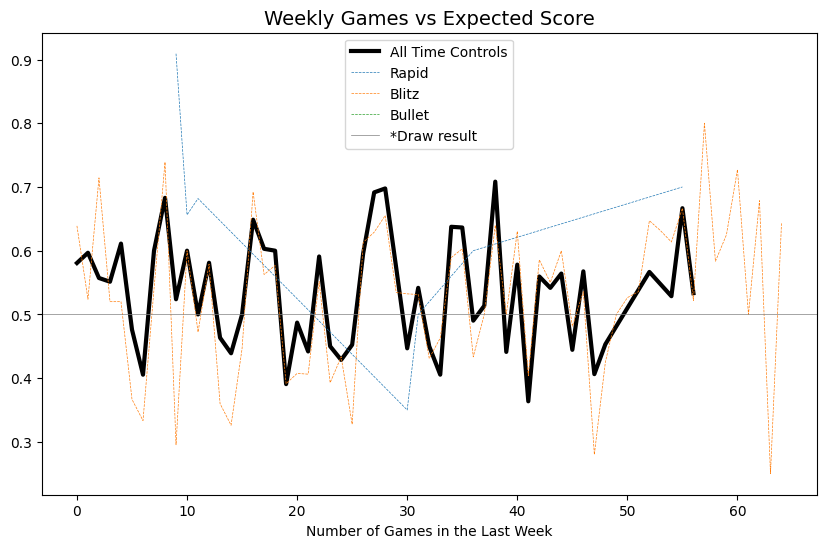

In [8]:
weekly_games_vs_result = my_games.groupby('games in last week')['numeric result'].agg(mean = 'mean', count = 'count')
weekly_games_vs_result = weekly_games_vs_result[weekly_games_vs_result['count'] >= 30]
weekly_games_vs_result = weekly_games_vs_result.reset_index()

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(weekly_games_vs_result['games in last week'], weekly_games_vs_result['mean'], label = 'All Time Controls', linewidth = 3, color = 'black')

plt.title('Weekly Games vs Expected Score', fontsize = 14)
plt.xlabel('Number of Games in the Last Week')

weekly_games_by_format = my_games.groupby(['time format', 'games in last week'])['numeric result'].agg(mean = 'mean', count = 'count').reset_index()
weekly_games_Rapid = weekly_games_by_format[weekly_games_by_format['time format'] == 'rapid']
weekly_games_Rapid = weekly_games_Rapid[weekly_games_Rapid['count'] >= 10]

weekly_games_Blitz = weekly_games_by_format[weekly_games_by_format['time format'] == 'blitz']
weekly_games_Blitz = weekly_games_Blitz[weekly_games_Blitz['count'] >= 10]

weekly_games_Bullet = weekly_games_by_format[weekly_games_by_format['time format'] == 'bullet']
weekly_games_Bullet = weekly_games_Bullet[weekly_games_Bullet['count'] >= 10]

ax.plot(weekly_games_Rapid['games in last week'], weekly_games_Rapid['mean'], label = 'Rapid', linewidth = 0.5, linestyle = '--')
ax.plot(weekly_games_Blitz['games in last week'], weekly_games_Blitz['mean'], label = 'Blitz', linewidth = 0.5, linestyle = '--')
ax.plot(weekly_games_Bullet['games in last week'], weekly_games_Bullet['mean'], label = 'Bullet', linewidth = 0.5, linestyle = '--')

ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw result', linewidth = 0.5)
ax.legend()

fig.savefig('Weekly Games vs Expected Result.png')

## ^^ Interestingly, it appears there is no correlation at all. Another interesting one is performance by rating difference.

/var/folders/01/mldp0g2d0h57s08vdtwnz8zh0000gn/T/ipykernel_3691/2911023485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_games_ratingfil['rating bucket'] =( ( (my_games_ratingfil['rating difference'] - null_bucket_min) // bucket_size ) * bucket_size ) + null_bucket_min


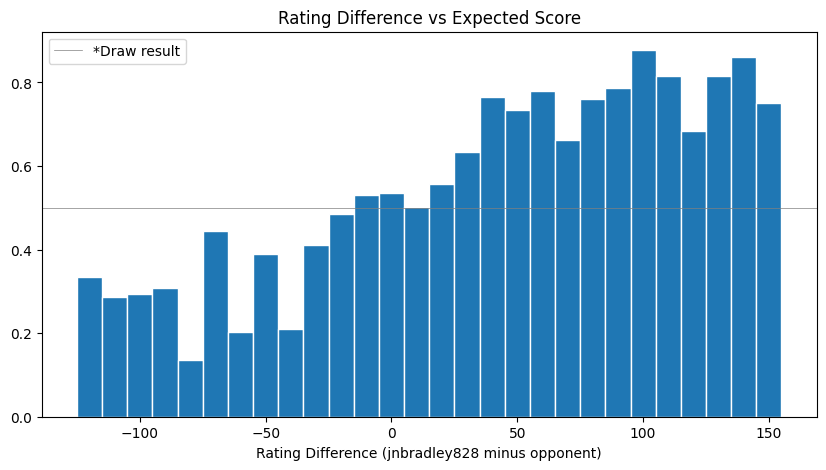

In [9]:
my_games['rating difference'] = my_games['my rating'] - my_games['opponent rating']
my_games_ratingfil = my_games[  (my_games['rating difference'] > my_games['rating difference'].quantile(.025)) & (my_games['rating difference'] < my_games['rating difference'].quantile(.975))  ]

##Let's group rating differences into buckets and analyze.
bucket_size = 10
null_bucket_min = -5

my_games_ratingfil['rating bucket'] =( ( (my_games_ratingfil['rating difference'] - null_bucket_min) // bucket_size ) * bucket_size ) + null_bucket_min
my_games_rating_data = my_games_ratingfil.groupby('rating bucket')['numeric result'].agg(count = 'count', mean = 'mean').reset_index()

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(my_games_rating_data['rating bucket'], my_games_rating_data['mean'], align = 'edge', width = 10, edgecolor = 'white')
ax.set_title('Rating Difference vs Expected Score')
ax.set_xlabel(f'Rating Difference ({my_username} minus opponent)')
ax.axhline(y=0.5, color='gray', linestyle='-', label='*Draw result', linewidth = 0.5, zorder = 2)


ax.legend()
fig.savefig('Rating Difference vs Expected Score.png')